# Imports

In [85]:
import os
import ast
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from datetime import date

from pennylane import numpy as np

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as sklearn_rbf_kernel

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

seed = 42

np.random.seed(seed)

# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}_quantun_space.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)

# Circuits

In [86]:
dev = qml.device("lightning.gpu", wires=4)

def statepreparation(x, wires):
    # Codificação paralela em múltiplas rotações
    for i in wires:
        qml.RY(x[0] * np.pi, wires=i)
        qml.RZ(x[1] * np.pi, wires=i)
    
    # Entrelaçamento não-linear inicial
    qml.CRZ(x[0]*x[1], wires=[wires[0], wires[1]])
    qml.CRX(x[0]**2, wires=[wires[2], wires[3]])

def apply_layer(W, n_entanglement):
    # Rotações diferenciadas por qubit
    for i in range(4):
        qml.Rot(W[i,0], W[i,1], W[i,2], wires=i)
    
    # Entrelaçamento adaptativo dinâmico
    pairs = [(0,1), (1,2), (2,3), (3,0)]  # Topologia circular
    for i, pair in enumerate(pairs[:n_entanglement+1]):
        qml.CNOT(wires=pair)
        qml.CRY(W[i,3], wires=pair)  # Parâmetro único por operação
    
    # Não-linearidade através de observáveis
    qml.Hadamard(wires=0)
    qml.CRZ(W[2,3], wires=[0,1])  # Parâmetro adicional

def circuit(weights, X, n_entanglement):
    wires = range(4)
    statepreparation(X, wires)

    for W in weights:
        apply_layer(W, n_entanglement)

    return [qml.expval(qml.PauliZ(i)) for i in wires]

def qvc_classifier(qnode, weights, bias, X):
    return qnode(weights, X)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type1(weights, X):
    return circuit(weights, X, 1)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type2(weights, X):
    return circuit(weights, X, 2)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type3(weights, X):
    return circuit(weights, X, 3)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type4(weights, X):
    return circuit(weights, X, 4)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type5(weights, X):
    return circuit(weights, X, 5)

# Cost Function

In [105]:
# Inicializa listas para armazenar as perdas
intra_loss_history = []
inter_loss_history = []
total_loss_history = []

def cost_function(
        weights, bias, centroids,
        # params, 
        qnode, 
        features, 
        alpha=1.0):
    # weights, bias, centroids = params
    global intra_loss_history, inter_loss_history, total_loss_history
    
   # Calcular embeddings com autograd
    embeddings = np.array([qvc_classifier(qnode, weights, bias, x) for x in features])
    
    # Aplicar softmax corretamente (com estabilidade numérica)
    similarities = np.dot(embeddings, centroids.T)
    max_s = np.max(similarities, axis=1, keepdims=True)
    exp_similarities = np.exp(similarities - max_s)  # Subtrai o máximo para estabilidade
    probabilities = exp_similarities / np.sum(exp_similarities, axis=1, keepdims=True)


    # Similaridades com qml.math.dot
    

    # probabilities = similarities / np.sum(similarities, axis=1, keepdims=True)
    # print(probabilities.dtype)
    # print(similarities.dtype)

    # print(probabilities)

    # 3. Calcular probabilidades via softmax manual
    # probabilities = softmax(similarities)  # Usar nossa implementação
    
    # 4. Calcular perdas
    intra_loss = -np.mean(probabilities * similarities)  # Maximizar similaridade intra-cluster
    inter_loss = -np.linalg.norm(centroids[0] - centroids[1])  # Maximizar distância inter-cluster

    # 5. NOVA PENALIDADE: Evitar colapso para único cluster
    mean_probs = np.mean(probabilities, axis=0)
    target_probs = np.ones_like(mean_probs)/centroids.shape[0]  # Distribuição uniforme
    balance_penalty = np.sum(mean_probs * np.log(mean_probs/target_probs + 1e-10))  # KL divergence
    
    # 6. Combinação final
    total_loss = intra_loss + alpha*inter_loss + balance_penalty
    
    # Combinação dinâmica
    # total_loss = intra_loss + alpha * inter_loss

    intra_loss_history.append(intra_loss)
    inter_loss_history.append(alpha * inter_loss)  # Já multiplicado pelo alpha

    # total_loss_history.append(total_loss)
    
    return total_loss

# Show Clusters

In [88]:
def show_clusters(weights, bias, qnode, features, centroids, x_max, y_max, complement=''):
    plt.figure()
    cmap = plt.cm.plasma
    
    # Cálculo das projeções com média móvel
    embeddings = np.array([qvc_classifier(qnode, weights, bias, x) for x in features])
        # Similaridades com qml.math.dot
    similarities = np.dot(embeddings, centroids.T)

    probabilities = similarities / np.sum(similarities, axis=1, keepdims=True)
    cluster_assignments = np.argmax(probabilities, axis=1)

    print(cluster_assignments)

    # Elementos comuns
    plt.scatter(features[:,0], features[:,1], c=cluster_assignments, 
               cmap=cmap, vmin=0, vmax=1, edgecolors='k')
    plt.title(f"Teste {complement}")
    plt.tight_layout()
    plt.show()

In [98]:
# Função para plotar a evolução
def plot_loss_evolution(show_window=True):
    plt.figure(figsize=(12, 6))
    
    epochs = range(1, len(intra_loss_history)+1)
    
    # plt.plot(epochs, total_loss_history, 'k--', label='Total Loss', alpha=0.8)
    plt.plot(epochs, intra_loss_history, 'b', label='Intra Loss (Variância)')
    plt.plot(epochs, inter_loss_history, 'r', label='Inter Loss (Separação)')
    # plt.plot(epochs, reg_loss_history, 'g', label='Reg Loss (L2)')
    
    plt.title('Evolução das Componentes da Função de Custo')
    plt.xlabel('Época')
    plt.ylabel('Valor da Loss')
    # plt.yscale('log')  # Usar escala logarítmica se as perdas variarem muito
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    
    if show_window:
        plt.show()
    else:
        plt.draw()
        plt.pause(0.001)  # Para atualização em tempo real

# Train Function

In [90]:
def train(
    qnode, 
    features,  
    n_parameters,
    n_qubits,
    n_layers, 
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    seed, 
    iterations=100, 
    batch_size=32,
    show_log=False
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)

    # Centróides dos clusters (inicializados aleatoriamente)
    centroids = np.random.normal(0, 1, size=(2, n_qubits), requires_grad=True)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_parameters), 
        requires_grad=True
    )
    bias_init = np.array(0.0, requires_grad=True)  

    weights = weights_init
    bias = bias_init

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "centroids": centroids,
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 15
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        # print(current_batch_size)
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]
        # Train model on batch
        wrapped_cost_function = lambda a, b, c: cost_function(a, b, c, qnode, X_train_batch)
        params = [weights, bias, centroids]
        (weights, bias, centroids), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        # weights, bias, centroids = params
        print(weights[0])
        print(bias)
        print(centroids)
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_cost'] = iteration_cost
            training_info['centroids'] = centroids
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        # # Visualização periódica
        # if it % 20 == 0:
        #     show_clusters(weights, bias, qnode, features, np.pi, np.pi, it)

        logger.info(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # # Early stopping if no improvement
        # if no_improvement >= patience:
        #     break


    if show_log:
        # Definir o grau do polinômio (ex: 2 para quadrático, 3 para cúbico)
        grau_polinomio = 4  # Tente aumentar para 3 ou 4 se necessário

        # Ajuste polinomial
        coef = np.polyfit(all_iterations, all_costs, grau_polinomio)
        poly_eq = np.poly1d(coef)  # Criar a equação polinomial

        # Gerar valores da curva ajustada
        iter_range = np.linspace(min(all_iterations), max(all_iterations), 100)  # Mais pontos para suavizar a curva
        trend_line = poly_eq(iter_range)

        # Plotar os dados originais
        plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")

        # Plotar a curva polinomial ajustada
        plt.plot(iter_range, trend_line, label=f"Aproximação Polinomial (grau {grau_polinomio})", linestyle="--", color="red")

        # Configurações do gráfico
        plt.title(f"Evolução da Função de Custo")
        plt.xlabel("Iteração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    val_embeddings = np.array([qvc_classifier(qnode, training_info['best_weights'], bias, x) for x in X_val])

    # Similaridades com qml.math.dot
    val_similarities = np.dot(val_embeddings, centroids.T)

    val_probabilities = val_similarities / np.sum(val_similarities, axis=1, keepdims=True)
    
    # val_similarities = np.array([[np.dot(e, c) for c in centroids] for e in val_embeddings])

    # val_probabilities = np.apply_along_axis(softmax, 1, val_similarities)
    val_cluster_assignments = np.argmax(val_probabilities, axis=1)

    # 3. Calcular métricas com verificação de dimensões
    if len(np.unique(val_cluster_assignments)) > 1:
        training_info['silhouette'] = silhouette_score(X_val, val_cluster_assignments)
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, val_cluster_assignments)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, val_cluster_assignments)
    else:
        training_info.update({
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        })
    
    # 3. Plotar regiões de decisão
    show_clusters(
        weights=training_info['best_weights'],
        bias=bias,
        qnode=qnode,
        features=X_val,
        centroids=training_info['centroids'],
        x_max=np.pi,
        y_max=np.pi,
        complement=f"{qnode.__name__} | Layers: {n_layers} | Optim: {optimizer.__name__}"
    )
    
    # 4. Logging dos resultados
    logger.info(f'Custo Final: {training_info["best_cost"]:.4f}')
    logger.info(f'Silhouette: {training_info["silhouette"]:.4f}')
    logger.info(f'Davies Bouldin: {training_info["davies_bouldin"]:.4f}')
    logger.info(f'Calinski Harabasz: {training_info["calinski_harabasz"]:.4f}')
    
    return (
        training_info["best_cost"],
        training_info["best_weights"],
        training_info["best_bias"],
        training_info["centroids"],
        training_info["silhouette"],
        training_info["davies_bouldin"],
        training_info["calinski_harabasz"]
    )

# Normalize

In [91]:
def normalize(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled

# Moon Dataset

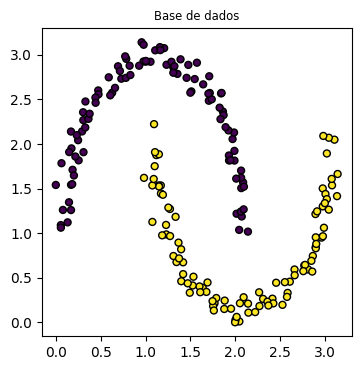

In [92]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=seed)

X = normalize(X, y, range_init=0, range_end=np.pi)

# Running

[[ 2.34945858  0.07260346  1.40155581 -2.49144125]
 [-1.72574788  1.26920603 -2.81722185 -0.08095842]
 [ 0.62258411  0.63439496 -3.00777839 -1.11659506]
 [ 0.85281134 -2.18366989  1.2196848   1.54519366]]
0.0
[[ 1.28174349  0.65543011 -0.41484649 -0.30030153]
 [-0.46490847 -0.4562847  -1.4878989  -1.71835792]]
[[ 2.34923503  0.08504344  1.40093032 -2.49596308]
 [-1.72369212  1.26086188 -2.82292753 -0.07620728]
 [ 0.62218738  0.62821633 -3.0159029  -1.11402801]
 [ 0.848543   -2.16098638  1.21065578  1.54519366]]
0.0
[[ 1.35445324  0.69385323 -0.37117807 -0.24696858]
 [-0.53599942 -0.50087607 -1.53303257 -1.7780581 ]]
[[ 2.34786761  0.09869748  1.39911059 -2.50157852]
 [-1.72297941  1.25198417 -2.82705356 -0.07064297]
 [ 0.62103262  0.62151546 -3.02430143 -1.11033199]
 [ 0.84274598 -2.14183089  1.20538062  1.54519366]]
0.0
[[ 1.42895141  0.73057568 -0.32613317 -0.19128509]
 [-0.60602371 -0.54599171 -1.57787343 -1.83893352]]
[[ 2.34961495  0.11558089  1.40007014 -2.50927393]
 [-1.72040729

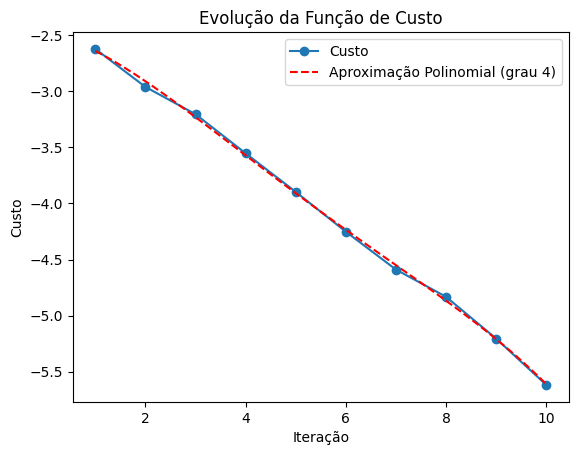

[0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1
 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0]


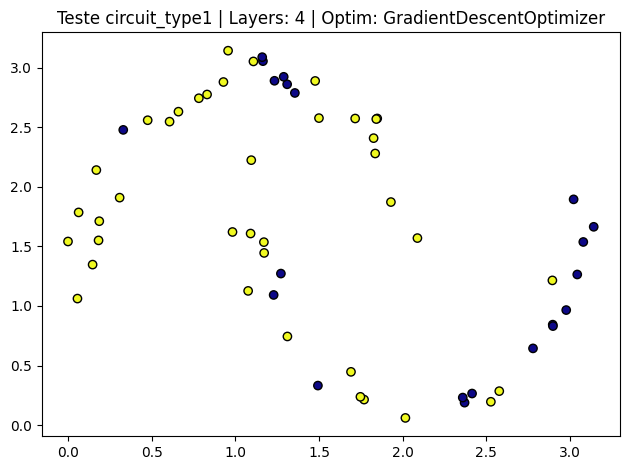

ValueError: setting an array element with a sequence.

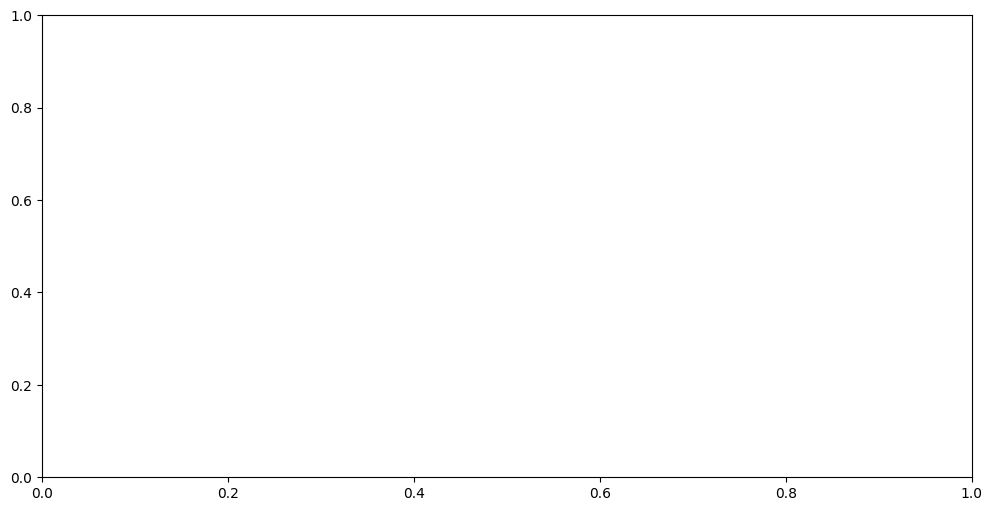

In [106]:
n_qubits = 4
n_parameters = 4
n_layers = 4
qnode = qml.QNode(circuit_type1, dev)

intra_loss_history = []
inter_loss_history = []
total_loss_history = []

cost, weights, bias, centroids, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_parameters=n_parameters,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=GradientDescentOptimizer,
    dic_optimizer={"stepsize": 0.1},
    seed=seed,
    iterations=10,
    batch_size=64,
    show_log=True
)

plot_loss_evolution(show_window=True)

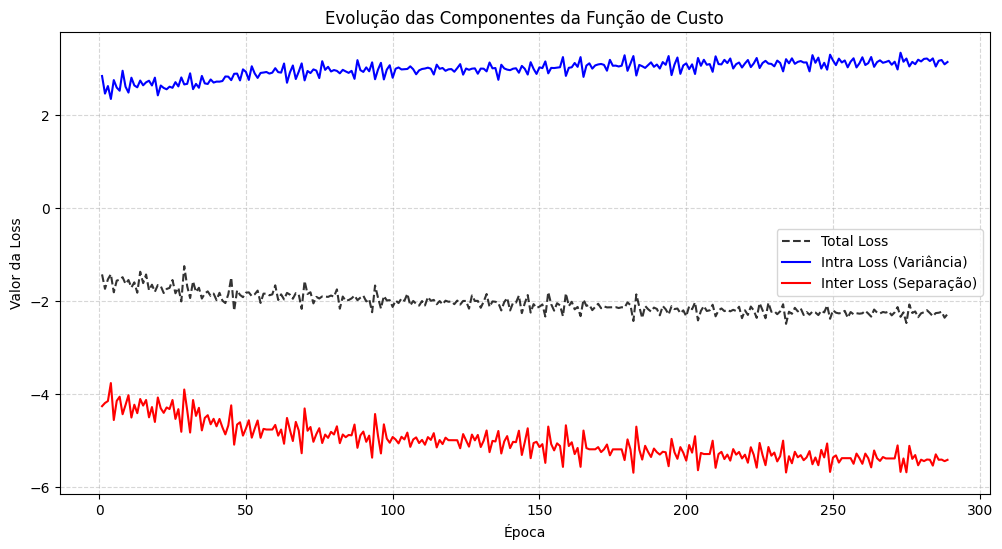

In [ ]:
plot_loss_evolution(show_window=True)

[0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0
 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0
 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0
 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0
 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0]


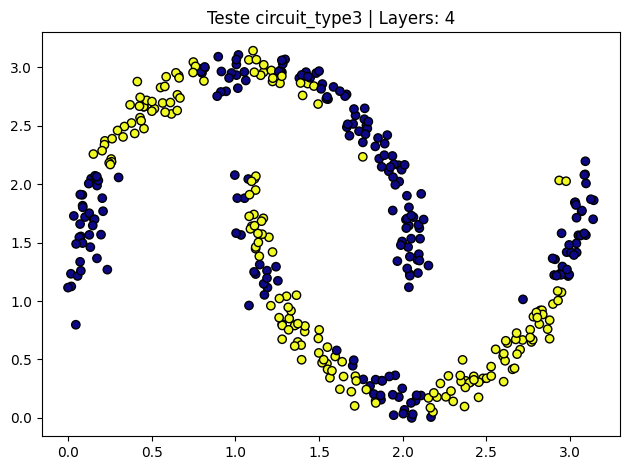

In [ ]:
show_clusters(
        weights=weights,
        bias=bias,
        qnode=qnode,
        features=X,
        centroids=centroids,
        x_max=np.pi,
        y_max=np.pi,
        complement=f"{qnode.__name__} | Layers: {n_layers}"
    )